# Monte-Carlo with importance sampling

## Setup

In [302]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

The math behind Monte-Carlo integration:

$$
\begin{align}
\mathbb{E}_{X \sim p}\left[ f(X) \right] 
\approx \sum_{n=1}^{N} f(x_i) \text{, where } x_i's \text{ are random samples from distribution } p 
\end{align}
$$

The math behind Monte-Carlo integration with ordinary importance sampling:

$$
\begin{align}
\mathbb{E}_{X \sim p}\left[ f(X) \right] 
&= \int_{-\infty}^{\infty} p(x) f(x) dx \notag \\
&= \int_{-\infty}^{\infty} q(x) \frac{p(x)}{q(x)}  f(x) dx \notag \\
&= \mathbb{E}_{X \sim q} \left[ \frac{p(x)}{q(x)}  f(x) \right] \notag \\ 
&\approx \frac{1}{N} \sum_{n=1}^{N} \frac{p(x_i)}{q(x_i)} f(x_i) \text{, where } x_i's \text{ are random samples from distribution } q
\end{align}
$$

Monte-Carlo integration with weighted importance sampling (I don't understand why though):

$$
\begin{align}
\mathbb{E}_{X \sim p}\left[ f(X) \right] \approx \frac{1}{\sum_{n=1}^{N}\frac{p(x_i)}{q(x_i)}} \sum_{n=1}^{N} \frac{p(x_i)}{q(x_i)} f(x_i) \text{, where } x_i's \text{ are random samples from distribution } q
\end{align}
$$

In [112]:
def f(x):
    return x ** 2

In [113]:
class NormalDistribution:
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        
    def sample(self, size, seed=None):
        return norm.rvs(loc=self.loc, scale=self.scale, size=size, random_state=seed)
    
    def density(self, x):
        return norm.pdf(x, loc=self.loc, scale=self.scale)

In [647]:
loc1=0; loc2=2
p = NormalDistribution(loc=loc1, scale=1)
q = NormalDistribution(loc=loc2, scale=1)

## Properties of ordinary and weighted IS

In [648]:
from tqdm.notebook import tqdm

In [649]:
mc_means_of_means, mc_vars_of_means = [], []
mcis_means_of_means, mcis_vars_of_means = [], []
mcisw_means_of_means, mcisw_vars_of_means = [], []

stepsize=10
stepsize2=100
Ns = np.concatenate([np.arange(10, 100+stepsize, stepsize), np.arange(100, 1000+stepsize2, stepsize2)])
for N in tqdm(Ns):
    
    p_samples = p.sample((10000, N))
    function_values = f(p_samples)
    mc_means = np.mean(function_values, axis=-1)
        
    mc_means_of_means.append(np.mean(mc_means))
    mc_vars_of_means.append(np.var(mc_means))
    
    # =========
    
    q_samples = q.sample((10000, N))

    weights = p.density(q_samples) / q.density(q_samples)
    function_values = f(q_samples)

    mcis_means = np.mean(weights * function_values, axis=-1)
    mcis_weighted_means = np.sum(weights * function_values, axis=-1) / np.sum(weights, axis=-1)
        
    mcis_means_of_means.append(np.mean(mcis_means))
    mcis_vars_of_means.append(np.var(mcis_means))
    
    mcisw_means_of_means.append(np.mean(mcis_weighted_means))
    mcisw_vars_of_means.append(np.var(mcis_weighted_means))

In [651]:
mc_means_of_means, mc_vars_of_means = np.array(mc_means_of_means), np.array(mc_vars_of_means)
mcis_means_of_means, mcis_vars_of_means = np.array(mcis_means_of_means), np.array(mcis_vars_of_means)
mcisw_means_of_means, mcisw_vars_of_means = np.array(mcisw_means_of_means), np.array(mcisw_vars_of_means)

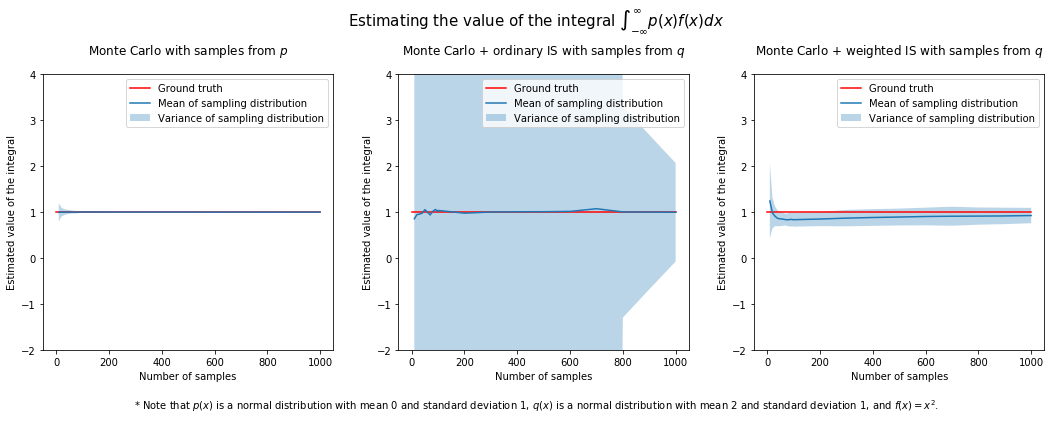

In [655]:
label1 = 'Ground truth'
label2 = 'Mean of sampling distribution'
label3 = 'Variance of sampling distribution'
ylim_lower, ylim_upper = -2, 4
xlabel = 'Number of samples'; ylabel='Estimated value of the integral'

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)

plt.plot([0, np.max(Ns)], [1, 1], color='red', label=label1)

plt.plot(Ns, mc_means_of_means, label=label2)
plt.fill_between(Ns, mc_means_of_means-mc_vars_of_means, mc_means_of_means+mc_vars_of_means, alpha=0.3, label=label3)
plt.ylim(ylim_lower, ylim_upper)
plt.legend()
plt.title(r'Monte Carlo with samples from $p$', y=1.05)
plt.xlabel(xlabel); plt.ylabel(ylabel)

fig.add_subplot(132)

plt.plot([0, np.max(Ns)], [1, 1], color='red', label=label1)
plt.plot(Ns, mcis_means_of_means, label=label2)
plt.fill_between(Ns, mcis_means_of_means-mcis_vars_of_means, mcis_means_of_means+mcis_vars_of_means, alpha=0.3, label=label3)
plt.ylim(ylim_lower, ylim_upper)
plt.legend()
plt.title(r'Monte Carlo + ordinary IS with samples from $q$', y=1.05)
plt.xlabel(xlabel); plt.ylabel(ylabel)

fig.add_subplot(133)

plt.plot([0, np.max(Ns)], [1, 1], color='red', label=label1)
plt.plot(Ns, mcisw_means_of_means, label=label2)
plt.fill_between(Ns, mcisw_means_of_means-mcisw_vars_of_means, mcisw_means_of_means+mcisw_vars_of_means, alpha=0.3, label=label3)
plt.ylim(ylim_lower, ylim_upper)
plt.legend()
plt.title(r'Monte Carlo + weighted IS with samples from $q$', y=1.05)
plt.xlabel(xlabel); plt.ylabel(ylabel)

plt.suptitle(r'Estimating the value of the integral $\int_{-\infty}^{\infty} p(x) f(x) dx$', y=1.07, fontsize=15)
plt.figtext(
    0.5, -0.05,
    r"* Note that $p(x)$ is a normal distribution with mean 0 and standard deviation 1, $q(x)$ is a normal distribution with mean 2 and standard deviation 1, and $f(x) = x^2$.", 
    horizontalalignment='center'
) 

plt.tight_layout()
plt.savefig('importance_sampling_comparison.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)